In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import numpy as np

import matplotlib.pyplot as plt

from mpmath import polylog

from sklearn.model_selection import train_test_split

import time

In [2]:
def generate_data(func, lower, upper, n_samples=100, n_dim=1):
    """
    Generates data in the form of a 2D (1D in case the function 
    is single-variable) tensor of variables for the function and neural network input
    as well as the function values for the generated tensor of variables.

    @param func      function to provide values for the variables
    @param lower     lower bounds of variables (list, tensor or scalar)
    @param upper     upper bounds of variables (list, tensor or scalar)
    @param n_samples number of points of data to generate
                     (default value is 100)
    @param n_dim     number of dimensions of the function func
                     (default value is 1)

    @returns         variables x and function values y
    """
    X_list = [torch.linspace(lower[n], upper[n], n_samples).view(n_samples, 1) for n in range(n_dim)]
    X = torch.cat(X_list, dim=1)
    
    y = func(X).view(n_samples, 1)
    
    return X, y

In [3]:
def find_upper_bound(X, y, epsilon, points_limit=1, lower_index=0):
    """
        Finds the upper bound of integration. In this case a point, 
        where the next function value is greater/lesser than the previous
        less than a given threshold.

        @param X            variable values
        @param y            function values
        @param epsilon      threshold
        @param points_limit limit of bound points number 
        @param lower_index  starting X value for the search
        
        @returns       the required variable values (can be many) 
                       or empty list if none found
    """
    X_points = []
    
    if len(X) != len(y):
        raise ValueError("There numbers of variable and function values are inequal!")
    
    for i in range(lower_index, len(y) - 1):
        diff = torch.abs(y[i] - y[i + 1])
        if diff < epsilon:
            X_points.append(X[i])
        if len(X_points) == points_limit:
            break
            
    return X_points

In [4]:
class MLP(nn.Module):
    """
        Нейросеть, которая будет обучаться приближать функцию одной переменной.
        
        Нейросеть имеет архитектуру:

        Входной слой (1 нейрон для переменной функции + смещение, линейная функция активации)
        Скрытый слой (произвольное количество нейронов + смещение, функция активации - сигмоида)
        Выходной слой (1 нейрон для приближенного значения функции, линейная функция активации)
    """
    def __init__(self, input_size, hidden_size):
        """
            Конструктор для нейросети.
            @param self        нейросеть (необходим для включения в класс)
            @param hidden_size размер скрытого слоя (размеры входного и выходного слоёв равны одному
                               в рамках данной задачи, так как у функции одна переменная и 
                               задача сводится к описанию функции, то есть числа, скаляра).
        """
        super(MLP, self).__init__()
        self.input_hidden_layer = nn.Linear(input_size, hidden_size) # инициализация входного и скрытого слоя, 
                                                     # размеры: 1 --> размер скрытого слоя
        self.sigmoid_activation = nn.Sigmoid() # инициализация функции активации скрытого слоя
        self.output_layer = nn.Linear(hidden_size, 1) # инициализация выходного слоя, 
                                                      # размеры: размер скрытого слоя --> 1
    
    def forward(self, x):
        """
            Функция распространения данных через нейросеть вперёд.
           
            @param self   нейросеть (необходим для включения в класс)
            @param x      данные
           
            @returns выход в выходном нейроне
        """
        x = self.input_hidden_layer(x) # данные прошли входной слой и аккумулирвоаны в скрытом слое
        x = self.sigmoid_activation(x) # данные прошли функцию активации скрытого слоя
        x = self.output_layer(x) # данные прошли выходной слой
        
        return x


def train_model(model, criterion, optimizer, x_train, y_train, epochs):
    """
        Trains the model.
        
        @param model        The model to be trained
        @param criterion    Loss function
        @param optimizer    Optimization algorithm
        @param x_train      Training inputs
        @param y_train      True labels
        @param epochs       Number of training epochs
    """
    loss_history = [] # история обучения (изменения функции потерь)
    start_time = time.time()
    for epoch in range(epochs):
        predictions = model(x_train) # все переменные проводятся через нейросеть 
                                     # и формируются предскзания значений функции
        loss = criterion(predictions, y_train) # вычисляется функция потерь на данной эпохе

        optimizer.zero_grad() # обнуляются градиенты перед обратным распространением ошибки
        loss.backward() # обратное распространение ошибки
        optimizer.step() # шаг оптимизации - обновление параметров модели 

        loss_history.append(loss.item()) # запись текущей функции потерь

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.10f}') # вывод информации об обучении
    total_time = time.time() - start_time  # Общее время обучения
    print(f'Time elapsed: {total_time:.2f} seconds')
    return loss_history # возвращается история обучения


def test_model(model, criterion, x_test, y_test):
    """
        Tests the model.
        
        @param model        The trained model
        @param criterion    Loss function
        @param x_test       Test inputs
        @param y_test       True labels
    """
    with torch.no_grad():  # отключение расчета градиентов 
                           # (расчет градиентов может происходить по умолчанию 
                           # даже без использования их потом, что излишне нагружает память)
        predictions = model(x_test)  # тестовые переменные проводятся через обученную модель
        loss = criterion(predictions, y_test)  # вычисляется функция потерь для тестового набора

    # Возвращаем вычисленную функцию потерь
    return loss.item()  # Возвращаем скалярное значение ошибки


def predict_with_model(model, x_test):
    """
        Uses the model to predict values based on x_test arguments.
    
        @param model        The trained model
        @param x_test       Test inputs
    """
    with torch.no_grad():
        predictions = model(x_test)

    return predictions


def extract_model_params(model):
    """
        Функция извлечения параметров нейросети.
        @param model модель, из которой необходимо извлеч параметры
        @returns 4 объекта типа numpy.array: смещения 1-го слоя, веса 1-го слоя,
                 смещения 2-го слоя, веса 2-го слоя
    """
    # detach() - возвращает выбранный параметр, numpy() конвертирует в формат numpy.array,
    # flatten() для весов преобразует векторы-столбцы в векторы-строки.
    b1 = model.input_hidden_layer.bias.detach().numpy() 
    w1 = model.input_hidden_layer.weight.detach().numpy()
    b2 = model.output_layer.bias.detach().numpy() 
    w2 = model.output_layer.weight.detach().numpy().flatten()
    
    return b1, w1, b2, w2

# Integration function

In [5]:
def get_NN_integral(alpha1, beta1, alpha2, beta2, b1, w1, b2, w2):
    """
        Функция, реализующая метод численного интегрирования функции одной переменной
        на основе параметров нейросети. Реализует формулы (6.1) и (6.2).

        @param alpha нижняя граница интегрирования
        @param beta  верхняя граница интегрирования
        @param b1    смещения между входным и скрытым слоями
        @param w1    веса между входным и скрытым слоями
        @param b2    смещения между скрытым и выходным слоями
        @param w2    веса между скрытым и выходным слоями

        @returns численный интеграл на основе параметров нейросети.
    """
    def Phi_j(alpha1, beta1, alpha2, beta2, b1_j, w1_1j, w1_2j):
        """
            Вложенная функция, реализующая разность полилогарифмов (6.2).

            @param alpha нижняя граница интегрирования
            @param beta  верхняя граница интегрирования
            @param b1_j  j-е смещение между входным и скрытым слоями
            @param w1_j  j-тый вес между входным и скрытым слоями

            @returns разность полилогарифмов (6.2)
        """
        term_1 = polylog(2, -np.exp(-b1_j - w1_1j * alpha1 - w1_2j * alpha2))
        term_2 = polylog(2, -np.exp(-b1_j - w1_1j * alpha1 - w1_2j * beta2))
        term_3 = polylog(2, -np.exp(-b1_j - w1_1j * beta1 - w1_2j * alpha2))
        term_4 = polylog(2, -np.exp(-b1_j - w1_1j * beta1 - w1_2j * beta2))
        
        return term_1 - term_2 - term_3 + term_4
   
    integral_sum = 0 
        
    for w2_j, w1_1j, w1_2j, b1_j in zip(w2, w1[:, 0], w1[:, 1], b1):
        phi_j = Phi_j(alpha1, beta1, alpha2, beta2, b1_j, w1_1j, w1_2j) 
        summ = w2_j * ((beta1 - alpha1) * (beta2 - alpha2) + phi_j / (w1_1j * w1_2j))
        integral_sum += summ
    
    return b2 * (beta1 - alpha1) * (beta2 - alpha2) + integral_sum 

# Physics task: Definition

\begin{equation}
    \int_{0}^{1}d\alpha\{\alpha^{a}(1 - \alpha)^b\}\int_{0}^{\infty}dt\{\frac{t^m}{(1+t)^n}F[z_{0}]\} \equiv I(a, b, m, n; F[z_{0}])  \tag{1}
\end{equation}
\begin{equation}   
    F[z_0] = \exp[-2z_0]  \tag{2}
\end{equation}
\begin{equation} 
    z_0 = tD + \frac{t}{1 + t}R^2  \tag{3}
\end{equation}
\begin{equation}     
    D = \alpha_1(b_1^{2}P^2 + m_1^2) + \alpha_2(b_2^{2}P^2 + m_2^2)  \tag{4}
\end{equation}
\begin{equation} 
        R^2 = (\alpha_1^{2}b_1^2 + \alpha_2^{2}b_2^2 + 2\alpha_{1}\alpha_{2}b_{1}b_2)P^2  \tag{5}
\end{equation}
\begin{equation} 
    b_1 = -\frac{m_1}{m_1 + m_2}  \tag{6}
\end{equation}
\begin{equation} 
    b_2 = \frac{m_2}{m_1 + m_2}  \tag{7}
\end{equation}
\begin{equation} 
    m_1 = m_2 = 0.7083333, P^2 = -1.665046  \tag{8}
\end{equation}

## Constants: general

These constants will be used for all of the calculations.

In [6]:
m1 = 0.7083333
m2 = 0.7083333
PP = -1.665046

## Alpha function

\begin{equation}
    \alpha^{a}(1 - \alpha)^b\ \tag{1.1}
\end{equation}

In [7]:
def alpha_func(alpha):
    return alpha ** a * (1 - alpha) ** b

## Second factor function

\begin{equation}
   \frac{t^m}{(1+t)^n}F[z_{0}]  \tag{1.2}
\end{equation}

As far as the integral function converges quickly the infinite upper bound of integration will be replaced with a constant. Later we will decide which constant to choose.

In [8]:
def b1_func():
    return - m1 / (m1 + m2)

def b2_func():
    return m2 / (m1 + m2)

def D_func(alpha):
    b1b1 = b1_func() ** 2
    b2b2 = b2_func() ** 2
    alpha1 = alpha
    alpha2 = 1 - alpha1
    
    return alpha1 * (b1b1 * PP + m1**2) + alpha2 * (b2b2 * PP + m2**2)

def RR_func(alpha):
    b1 = b1_func()
    b2 = b2_func()
    b1b1 = b1 ** 2
    b2b2 = b2 ** 2
    alpha1 = alpha
    alpha2 = 1 - alpha1
    
    return (alpha1**2 * b1b1 + alpha2**2 * b2b2 + 2 * alpha1 * alpha2 * b1 * b2) * PP

def z0_func(t, alpha):
    D = D_func(alpha)
    RR = RR_func(alpha)
    return t * D + t / (1 + t) * RR

def F_func(t, alpha):
    z_0 = z0_func(t, alpha)
    return np.exp(-2*z_0)

Для того, чтобы определить подынтегральную функцию и на её основе создать обучающую и тестовую выборки необходимо преобразовать выражение (1):

\begin{equation}
 \int_{0}^{1} \alpha^{a}(1 - \alpha)^bd\alpha \int_{0}^{\infty}\frac{t^m}{(1+t)^n}F[z_{0}]dt = 
 \int_{0}^{1} \int_{0}^{\infty}\frac{t^m}{(1+t)^n}F[z_{0}]\alpha^{a}(1 - \alpha)^bdtd\alpha 
\end{equation}

In [9]:
def t_alpha_func(t, alpha):
    return (t ** m) / ((1 + t) ** n) * F_func(t, alpha) * alpha_func(alpha)

def main_function(X):
    t = X[:, 0]
    alpha = X[:, 1]

    return t_alpha_func(t, alpha)

## $F[z_o]$: addition

The further computation will require a derivative of the (2) function, so it should be declared here. The derivative is equal to

\begin{equation}
    F'[z_0] = -2\exp[-2z_0] \tag{9}
\end{equation}

In [10]:
def F_derivative(t):
    return -2 * F_func(t)

def t_func_with_F_der(t):
    return t ** m / (1 + t) ** n * F_derivative(t)    

# NN Integration: first run

The constants are:

In [11]:
a = 0
b = 1
m = 2
n = 2

## Dataset

In [12]:
X, y = generate_data(func=main_function, lower=[0, 0], upper=[100, 1], n_samples=10000, n_dim=2)

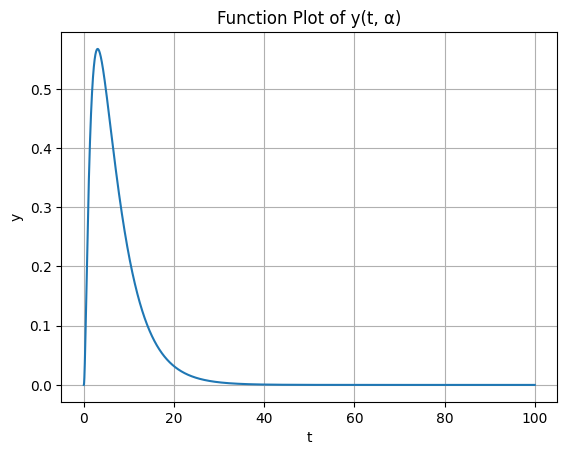

In [13]:
t = X[:, 0].numpy()
y_np = y.numpy()
plt.plot(t, y)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t, α)')
plt.grid(True)
plt.show()

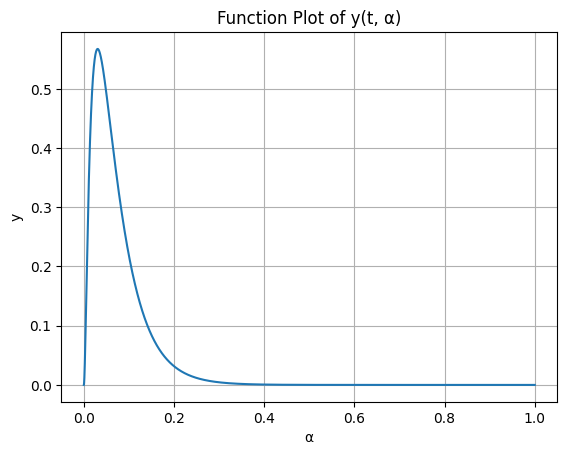

In [14]:
alpha = X[:, 1].numpy()
y_np = y.numpy()
plt.plot(alpha, y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(t, α)')
plt.grid(True)
plt.show()

As far as the t variable has its upper bound equal to $\infty$ let's find the point at which the $y(t)$ stops to change rapidly $|y(t_i) - y(t_{i+1})| < \epsilon)$. This $t_i$ is going to be the upper bound of the integration.

In [15]:
upper_bound_t = find_upper_bound(X=X[:, 0], y=y, epsilon=0.0000001, points_limit=1, lower_index=2000) # the 2000 value should be around t=20 based on graph
upper_bound_t

[tensor(53.0053)]

We see that function $y(t)$ should be integrated within bounds $[0, $ upper_bound_t$]$

## Integration bounds

$a_1, b_1$ for (1.1), $a_2, b_2$ for (1.2).

In [16]:
a1 = 0.0000000 # α lower
b1 = 1.0000000 # α upper
a2 = 0.0000000 # t lower
b2 = upper_bound_t[0].item() # t upper

a1, a2, b1, b2

(0.0, 0.0, 1.0, 53.00530242919922)

## Datasets based on bounds

In [17]:
X, y = generate_data(func=main_function, lower=[a2, a1], upper=[b2, b1], n_samples=10000, n_dim=2)

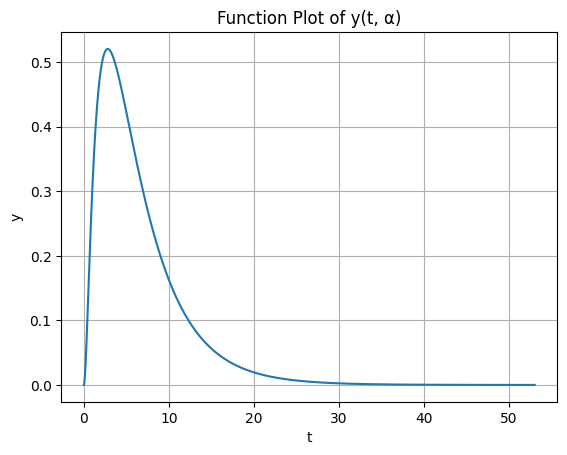

In [18]:
t = X[:, 0].numpy()
y_np = y.numpy()
plt.plot(t, y)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t, α)')
plt.grid(True)
plt.show()

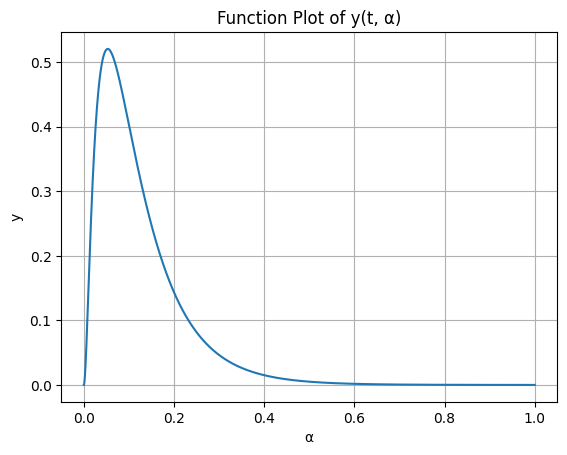

In [19]:
alpha = X[:, 1].numpy()
y_np = y.numpy()
plt.plot(alpha, y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(t, α)')
plt.grid(True)
plt.show()

## Train-test datasets split

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1) # 10% from Lloyd's at all. "Using..."

In [21]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([9000, 2]),
 torch.Size([1000, 2]),
 torch.Size([9000, 1]),
 torch.Size([1000, 1]))

## Model

### Hyperparams for the NN model

In [22]:
input_size = 2
hidden_size = 10
learning_rate = 0.001
num_epochs = 1000

### Model definition, compilation and training

In [23]:
model = MLP(input_size, hidden_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs)

Epoch [100/1000], Loss: 0.0045551020
Epoch [200/1000], Loss: 0.0035420561
Epoch [300/1000], Loss: 0.0027343358
Epoch [400/1000], Loss: 0.0019425031
Epoch [500/1000], Loss: 0.0012595609
Epoch [600/1000], Loss: 0.0007413082
Epoch [700/1000], Loss: 0.0004018924
Epoch [800/1000], Loss: 0.0002050568
Epoch [900/1000], Loss: 0.0001000984
Epoch [1000/1000], Loss: 0.0000474019
Time elapsed: 1.23 seconds


In [24]:
summary(model, (input_size,)) # (input_size, ) - input shape

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              30
           Sigmoid-2                   [-1, 10]               0
            Linear-3                    [-1, 1]              11
Total params: 41
Trainable params: 41
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


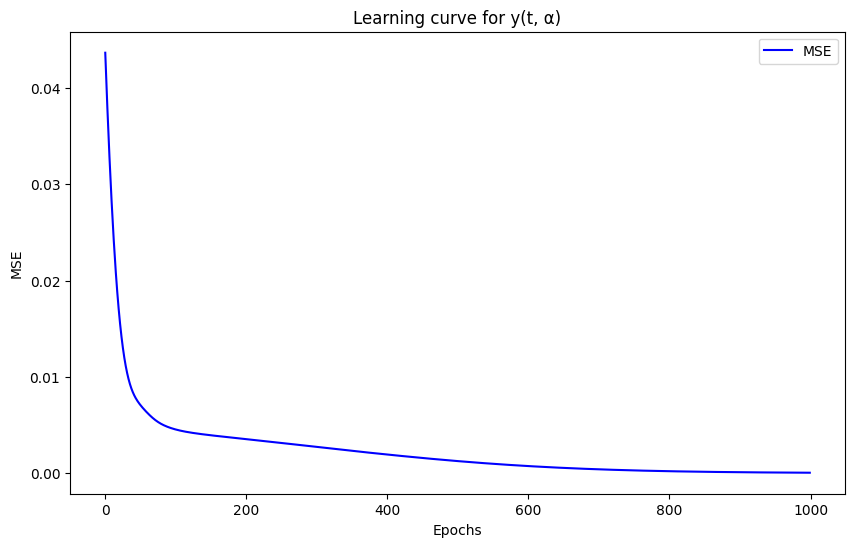

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for y(t, α)')
plt.legend()
plt.grid(False)
plt.show()

### Model testing

In [26]:
test_loss = test_model(model, criterion, x_test, y_test)
print(f"Test Loss: {test_loss:.10f}")

Test Loss: 0.0000462152


## Model usage

In [27]:
bs1, we1, bs2, we2 = extract_model_params(model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10, 2), (1,), (10,))

In [28]:
bs1, we1[:, 0], we1[:, 1], bs2, we2

(array([ 0.01881911,  0.53084457,  0.31967887,  0.6864367 ,  0.5868786 ,
        -0.04200107, -0.04637356,  0.12944928, -0.34108153, -0.7082344 ],
       dtype=float32),
 array([ 1.0354434e-04, -1.2873191e+00, -2.0238198e-01, -2.3114666e-01,
         9.5351748e-02, -2.2668417e-01, -5.9265184e-01, -1.1045114e+00,
         2.3534717e-01,  2.5989112e-01], dtype=float32),
 array([-0.30550602, -0.5153509 ,  0.44670013, -0.06900083, -0.7190679 ,
         0.39254433, -0.38376772, -0.8914462 , -0.11641008,  0.50157714],
       dtype=float32),
 array([0.08505379], dtype=float32),
 array([-0.14831313, -0.69047374,  0.39417893,  0.45832768,  0.11096592,
         0.45219946, -0.15519209, -0.5052696 , -0.08286084, -0.0436173 ],
       dtype=float32))

In [29]:
nni = get_NN_integral(a1, b1, a2, b2, bs1, we1, bs2, we2)

nni

array([mpf('50.224385449815756')], dtype=object)

In [30]:
def test_NNI_2d(repeat = 10):

    test_losses = []
    nnis = []

    for _ in range(repeat):
        model = MLP(input_size, hidden_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs)
        
        test_losses.append(test_model(model, criterion, x_test, y_test))
    
        bs1, we1, bs2, we2 = extract_model_params(model)
        nnis.append(get_NN_integral(a1, b1, a2, b2, bs1, we1, bs2, we2))

    return test_losses, nnis

In [31]:
losses, integrals = test_NNI_2d()

Epoch [100/1000], Loss: 0.0158719495
Epoch [200/1000], Loss: 0.0061327796
Epoch [300/1000], Loss: 0.0033783924
Epoch [400/1000], Loss: 0.0026388464
Epoch [500/1000], Loss: 0.0023133308
Epoch [600/1000], Loss: 0.0021098501
Epoch [700/1000], Loss: 0.0019500016
Epoch [800/1000], Loss: 0.0018057983
Epoch [900/1000], Loss: 0.0016667381
Epoch [1000/1000], Loss: 0.0015291574
Time elapsed: 1.11 seconds
Epoch [100/1000], Loss: 0.3380717039
Epoch [200/1000], Loss: 0.0182310138
Epoch [300/1000], Loss: 0.0073340479
Epoch [400/1000], Loss: 0.0044365660
Epoch [500/1000], Loss: 0.0037348070
Epoch [600/1000], Loss: 0.0033877930
Epoch [700/1000], Loss: 0.0031848298
Epoch [800/1000], Loss: 0.0030413386
Epoch [900/1000], Loss: 0.0029204555
Epoch [1000/1000], Loss: 0.0028074461
Time elapsed: 1.35 seconds
Epoch [100/1000], Loss: 0.0284837950
Epoch [200/1000], Loss: 0.0053798263
Epoch [300/1000], Loss: 0.0039581386
Epoch [400/1000], Loss: 0.0034548000
Epoch [500/1000], Loss: 0.0032252546
Epoch [600/1000], L

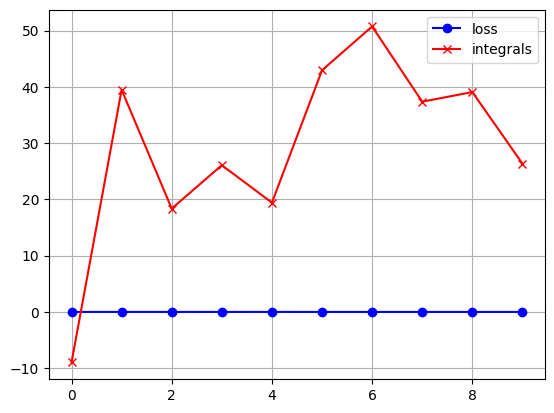

In [32]:
plt.plot(losses, label='loss', color='blue', marker='o')
plt.plot(integrals, label='integrals', color='red', marker='x')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
losses, integrals

([0.001589213963598013,
  0.0029713923577219248,
  0.002435246016830206,
  0.001419520820491016,
  0.0026470194570720196,
  0.0007605584105476737,
  0.0009702392271719873,
  0.0010501296492293477,
  0.001742271357215941,
  0.0016068076947703958],
 [array([mpf('-8.9794921840190227')], dtype=object),
  array([mpf('39.465493767076822')], dtype=object),
  array([mpf('18.365078243944868')], dtype=object),
  array([mpf('26.071697839195259')], dtype=object),
  array([mpf('19.409057726551701')], dtype=object),
  array([mpf('42.94045543016815')], dtype=object),
  array([mpf('50.718157600157618')], dtype=object),
  array([mpf('37.354142333626427')], dtype=object),
  array([mpf('39.063826457785886')], dtype=object),
  array([mpf('26.351044066664755')], dtype=object)])

In [34]:
def z(xy):
    x = xy[:, 0]
    y = xy[:, 1]

    return x*x + y*y

In [35]:
xy, zs = generate_data(z, lower=[-1, -1], upper=[1, 1], n_dim=2, n_samples=10)
xy, zs

(tensor([[-1.0000, -1.0000],
         [-0.7778, -0.7778],
         [-0.5556, -0.5556],
         [-0.3333, -0.3333],
         [-0.1111, -0.1111],
         [ 0.1111,  0.1111],
         [ 0.3333,  0.3333],
         [ 0.5556,  0.5556],
         [ 0.7778,  0.7778],
         [ 1.0000,  1.0000]]),
 tensor([[2.0000],
         [1.2099],
         [0.6173],
         [0.2222],
         [0.0247],
         [0.0247],
         [0.2222],
         [0.6173],
         [1.2099],
         [2.0000]]))

In [36]:
xy, zs = generate_data(z, lower=[-1, -1], upper=[1, 1], n_dim=2, n_samples=100000)

In [37]:
input_size = 2
hidden_size = 100
learning_rate = 0.001
num_epochs = 10000

In [38]:
model = MLP(input_size, hidden_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_history = train_model(model, criterion, optimizer, xy, zs, num_epochs)

Epoch [100/10000], Loss: 0.3535645008
Epoch [200/10000], Loss: 0.3468709290
Epoch [300/10000], Loss: 0.3371406198
Epoch [400/10000], Loss: 0.3210240602
Epoch [500/10000], Loss: 0.2920791805
Epoch [600/10000], Loss: 0.2413676977
Epoch [700/10000], Loss: 0.1671063602
Epoch [800/10000], Loss: 0.0900334790
Epoch [900/10000], Loss: 0.0400827341
Epoch [1000/10000], Loss: 0.0207330622
Epoch [1100/10000], Loss: 0.0154622998
Epoch [1200/10000], Loss: 0.0135828834
Epoch [1300/10000], Loss: 0.0122843515
Epoch [1400/10000], Loss: 0.0111529641
Epoch [1500/10000], Loss: 0.0101422751
Epoch [1600/10000], Loss: 0.0092392564
Epoch [1700/10000], Loss: 0.0084325066
Epoch [1800/10000], Loss: 0.0077111046
Epoch [1900/10000], Loss: 0.0070649297
Epoch [2000/10000], Loss: 0.0064848657
Epoch [2100/10000], Loss: 0.0059628212
Epoch [2200/10000], Loss: 0.0054916809
Epoch [2300/10000], Loss: 0.0050652437
Epoch [2400/10000], Loss: 0.0046781232
Epoch [2500/10000], Loss: 0.0043256413
Epoch [2600/10000], Loss: 0.004003

In [39]:
bs1, we1, bs2, we2 = extract_model_params(model)


In [40]:
nni = get_NN_integral(a1, b1, a2, b2, bs1, we1, bs2, we2)

nni

array([mpf('258.00706514987496')], dtype=object)